-entrenamos en GBL
-entrenamos en GBL + otros solventes
-testeamos en ambos casos en GBL, no habia cols de solventes

- luego lo encodeamos y repetimos lo mismo
- no vemos que se vea afectada, seguimos igual pero con esa info




In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from src.config import chemical_inventory_path, raw_data_path
from src.data import notebook_utils as utils
from src.constants import GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY, \
                        INCHI_TO_CHEMNAME, TARGET_COL, RXN_FEAT_NAME, ORGANOAMONIUM_INCHI_KEY_COL
from src import plot_utils
from pathlib import Path

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.reload_library()
import matplotlib.patches as mpatches
import seaborn as sns

In [3]:
solvent_exp_dir = Path("../../results2/")
solvent_drop_dir = Path("../../results3/")
solvent_exp_2 = Path("../../results_exp_2/")

In [91]:
solvent_exp_1 = Path("results/solvent_exp_1_gbc/")
solvent_exp_2 = Path("results/solvent_exp_2_gbc/")

In [49]:
solvents_inchies = [GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY]
solvents = [INCHI_TO_CHEMNAME[inchie] for inchie in solvents_inchies]

In [50]:
keywords_encoded_solvent = ["rf", INCHI_TO_CHEMNAME[GBL_INCHI_KEY]]
no_keywords_dropped_solvent = ["encoded"]

In [51]:
solvents

['Gamma-Butyrolactone', 'Dimethyl sulfoxide', 'Dimethylformamide']

In [52]:
sv_keywords = {'GBL': 'Gamma-Butyrolactone',
               'DMSO': 'Dimethyl sulfoxide',
               'DMF': 'Dimethylformamide'}

In [53]:
# Experiment 2
# Sample from each solvent evaluated in:
# 1. specific model MONO
# 2. multisolvent model MULTI


algorithms = ["rf"]

def get_experiment_solvent_2():
    exp_tags_preffix = ["MONO_", "MULTI_"]
    files_keys = ["model_per", "multisolvent"]

    experiments_info = {}
    for tag_preffix, files_key in zip(exp_tags_preffix, files_keys):
        for sv, sv_name in sv_keywords.items():
            exp_info = {"keywords": [sv_name, files_key]
                       }
            experiments_info[tag_preffix+sv] = exp_info
    return experiments_info


# Experient 1
# same sample evaluated in:
# ENCODED_SOLV
# NO_SOLV

algorithms = ["rf"]

def get_experiment_solvent_1():
    exp_tags = ["ENCODED_SOLV", "NO_SOLV"]
    files_keys = ["multisolvente", "no_solvent"]
    experiments_info = {}
    for tag, files_key in zip(exp_tags, files_keys):
        exp_info = {"keywords": [files_key]
                    }
        experiments_info[tag] = exp_info
    return experiments_info

In [81]:
experiments_info_2 = get_experiment_solvent_2()
experiments_info_2

{'MONO_GBL': {'keywords': ['Gamma-Butyrolactone', 'model_per']},
 'MONO_DMSO': {'keywords': ['Dimethyl sulfoxide', 'model_per']},
 'MONO_DMF': {'keywords': ['Dimethylformamide', 'model_per']},
 'MULTI_GBL': {'keywords': ['Gamma-Butyrolactone', 'multisolvent']},
 'MULTI_DMSO': {'keywords': ['Dimethyl sulfoxide', 'multisolvent']},
 'MULTI_DMF': {'keywords': ['Dimethylformamide', 'multisolvent']}}

In [82]:
experiments_info_1 = get_experiment_solvent_1()
experiments_info_1

{'ENCODED_SOLV': {'keywords': ['multisolvente']},
 'NO_SOLV': {'keywords': ['no_solvent']}}

In [56]:
def load_files_containing(dir_src_path, key_words, not_keywords=[], extension='csv'):
    files = [file_path for file_path in dir_src_path.iterdir() \
                if all(keyword in file_path.as_posix() for keyword in key_words)
                and not any(keyword in file_path.as_posix() for keyword in not_keywords)]
    return files

def load_melted_classi_report(path, experiment_tag):
    report_index = ['No cristaliza', 'Cristaliza', 'accuracy',
                    'macro avg', 'weighted avg']
    df = pd.read_csv(path)
    df['Clase'] = report_index
    df = df.melt(id_vars=['Clase'], 
                 value_vars=['precision', 'recall','f1-score', 'support', 'matthew'],
                 value_name='Score', var_name='Métrica'
                )
    df["Tipo"] = experiment_tag
    return df

def merge_files(files_dir, experiments_info):
    experiments_data = []
    
    for experiment_tag, exp_info in experiments_info.items():
        keywords = exp_info["keywords"]
        exp_files_list = load_files_containing(files_dir, key_words=keywords)
        df_exp_data = pd.concat([load_melted_classi_report(file, experiment_tag) for file 
                                                        in exp_files_list],
                                   axis=0)
        experiments_data.append(df_exp_data)

    return pd.concat(experiments_data, axis=0)

In [109]:
df_exp_2 = merge_files(solvent_exp_2, experiments_info_2)

In [138]:
#df_exp_2[df_exp_2["Solvente"]=='DMF'].head(40)

In [110]:
df_exp_1 = merge_files(solvent_exp_1, experiments_info_1)

In [107]:
def plot_classes(df):
    df = df[df['Métrica'] != 'support']
    df = df.loc[df['Clase'].isin(['No cristaliza','Cristaliza'])]
    return df

/home/belu/VS Workplace/licentiate-thesis-repo


In [140]:
folter = "figures/"
def plot_biboxplot(merge_class_report_by_class):
    plot_title = "../../figures/boxplot_multisolvent_exp_same_testingset.pdf"
    
    with plt.style.context(['science', 'bright']):
        bright = sns.color_palette()
    
        bright = plot_utils.tol_cset("bright")
    
    with plt.style.context(['science', 'bright']):
        g = sns.catplot(x="Métrica", y="Score",
                    hue="Tipo", col='Clase', col_wrap=2, height=3, aspect=1.2,
                    col_order=["Cristaliza", "No cristaliza"], palette=[bright.red, bright.grey],
                    kind='box', sharey=True, sharex=True, data=merge_class_report_by_class, legend=False)
        for ax in g.axes:
            #ax.set_yticklabels(rotation=90)
            ax.tick_params(labelbottom=True, which="both", left=True, bottom=False, top=False, right=False)
        plt.subplots_adjust(bottom=0.1, left=0.06, hspace=0.2)
        pop_a = mpatches.Patch(facecolor=bright.red, label="multisolvente (GBL+DMSO+DMF)", edgecolor='grey')
        pop_b = mpatches.Patch(facecolor=bright.grey, label="monosolvente (GBL)", edgecolor='grey')

        plt.legend(handles=[pop_a,pop_b])
        
        #plt.figure(figsize=(12,8))

        #plt.legend(title='', labels=["multisolvente (GBL+DMSO+DMF)", "monosolvente (GBL)"], facecolor=True)
        plt.savefig(plot_title, dpi=300)
        plt.ylim((0.55, 0.95))
        
        #plt.show()
        
def plot_biboxplot_2(merge_class_report_by_class):
    plot_title = "../../figures/boxplot_drop_solvent_exp.pdf"
    
    with plt.style.context(['science', 'bright']):
        bright = sns.color_palette()
    
        bright = plot_utils.tol_cset("bright")
    
    with plt.style.context(['science', 'bright']):
        g = sns.catplot(x="Métrica", y="Score",
                    hue="Tipo", col='Clase', col_wrap=2, height=3, aspect=1.2,
                    col_order=["Cristaliza", "No cristaliza"], palette=[bright.cyan, bright.grey],
                    kind='box', sharey=True, sharex=True, data=merge_class_report_by_class, legend=False)
        for ax in g.axes:
            #ax.set_yticklabels(rotation=90)
            ax.tick_params(labelbottom=True, which="both", left=True, bottom=False, top=False, right=False)
        plt.subplots_adjust(bottom=0.1, left=0.06, hspace=0.2)
        pop_a = mpatches.Patch(facecolor=bright.cyan, label="trained GBL+DMSO+DMF s/sv", edgecolor='grey')
        pop_b = mpatches.Patch(facecolor=bright.grey, label="trained GBL s/sv", edgecolor='grey')

        plt.legend(handles=[pop_a,pop_b])
        
        #plt.figure(figsize=(12,8))

        #plt.legend(title='', labels=["multisolvente (GBL+DMSO+DMF)", "monosolvente (GBL)"], facecolor=True)
        plt.savefig(plot_title, dpi=300)
        plt.ylim((0.55, 0.95))
        #plt.show()
        
def exp_1_boxplot_classes(df, plot_name="exp_1_unknown_plot.pdf"):
    plot_title = "figures/solvent/"+plot_name
    with plt.style.context(['science', 'bright']):
        bright = plot_utils.tol_cset("bright")
        g = sns.catplot(x="Métrica", y="Score",
                    hue="Tipo", col='Clase', col_wrap=2, height=3, aspect=1.2,
                    col_order=["Cristaliza", "No cristaliza"], 
                    palette=[bright.red, bright.grey],
                    kind='box', sharey=False, sharex=True, data=df, legend=True)
        for ax in g.axes:
            #ax.set_yticklabels(rotation=90)
            ax.tick_params(labelbottom=True, which="both", left=True, bottom=False, top=False, right=False)
        g.set(xlabel=None)
        g._legend.set_title(" ")
    #for ax in g.axes:
        #ax.set_yticklabels(rotation=90)
     #   ax.tick_params(labelbottom=True, which="both", left=True, bottom=False, top=False, right=False)
    #plt.subplots_adjust(bottom=0.1, left=0.06, hspace=0.2)
    #pop_a = mpatches.Patch(facecolor=bright.red, label="multisolvente (GBL+DMSO+DMF)", edgecolor='grey')
    #pop_b = mpatches.Patch(facecolor=bright.grey, label="monosolvente (GBL)", edgecolor='grey')
        g.savefig(plot_title, dpi=300)
    #plt.legend(handles=[pop_a,pop_b])
    
def exp_1_boxplot(df, plot_name="exp_1_unknown_plot.pdf"):  
    plot_title = "figures/solvent/"+plot_name
    
    with plt.style.context(['science', 'bright']):
        bright = plot_utils.tol_cset("bright")
        g = sns.catplot(x="Tipo", y="Score",
                col='Métrica', col_wrap=6, height=3, aspect=1.2,
                #col_order=["Cristaliza", "No cristaliza"], 
                palette=[bright.red, bright.grey],
                kind='box', sharey=True, sharex=True, data=df, legend=True)
        for ax in g.axes:
            #ax.set_yticklabels(rotation=90)
            #ax.grid(False, axis='y', color='black', linestyle='-', linewidth=0.5)
            ax.tick_params(labelbottom=True, which="both", left=True, bottom=False, top=False, right=False)     
#        for ax in g.axes.flat:
 #           ax.grid(True, axis='y')
        g.set(xlabel=None)
        #sns.despine(bottom = False, left = False, trim=False)
        g.savefig(plot_title, dpi=300)
        
    
def exp_2_boxplot(df, shared_y=True, plot_name="exp_2_unknown_plot.pdf"):
    plot_title = "figures/solvent/"+plot_name
    
    with plt.style.context(['science', 'bright']):
        bright = plot_utils.tol_cset("bright")
        g = sns.catplot(x="Métrica", y="Score",
                    hue="Exp", col='Solvente', col_wrap=2, height=3, aspect=1.2,
                    #col_order=["Cristaliza", "No cristaliza"], 
                    palette=[bright.grey, bright.cyan,],
                    kind='box', sharey=shared_y, sharex=True, data=df, legend=True)
        g.set(xlabel=None)
        g._legend.set_title(" ")

        for ax in g.axes:
            #ax.set_yticklabels(rotation=90)
            ax.tick_params(labelbottom=True, which="both", left=True, bottom=False, top=False, right=False)
        #plt.subplots_adjust(bottom=0.1, left=0.06, hspace=0.2)

        g.savefig(plot_title, dpi=300)
        
def filter_metrics(df):
    df = df[(df["Métrica"] != "matthew") & (df["Métrica"] != "support")]    
    df = df[df["Clase"].isin(["weighted avg", "macro avg"])]
    return df

def filter_metrics_classes(df):
    df = df[(df["Métrica"] != "matthew") & (df["Métrica"] != "support")]
    df = df[df["Clase"].isin(["Cristaliza", "No cristaliza"])]
    return df


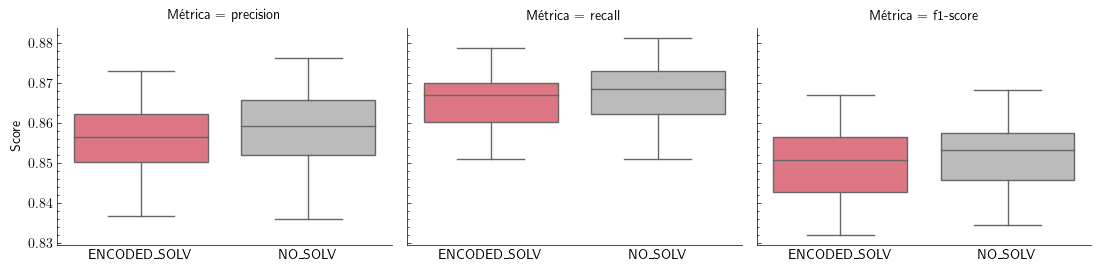

In [149]:
df_box_exp_1 = filter_metrics(df_exp_1)

def exp_1_final_no_matt(df):
    df = df[df["Clase"] == "weighted avg"]
    df = df[df["Métrica"] != "matthew"]
    return df

exp_1_boxplot(exp_1_final_no_matt(df_box_exp_1), plot_name="exp_1_prec_recall_f1_gbc_wei.pdf")

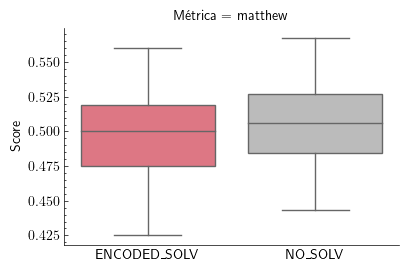

In [150]:
#df_exp_1 = merge_files(solvent_exp_1, experiments_info_1)
df_exp_1_matt = df_exp_1[(df_exp_1["Métrica"] == "matthew") & (df_exp_1["Clase"] == "weighted avg")]
exp_1_boxplot(df_exp_1_matt, plot_name="exp_1_mathew_gbc_wei.pdf")

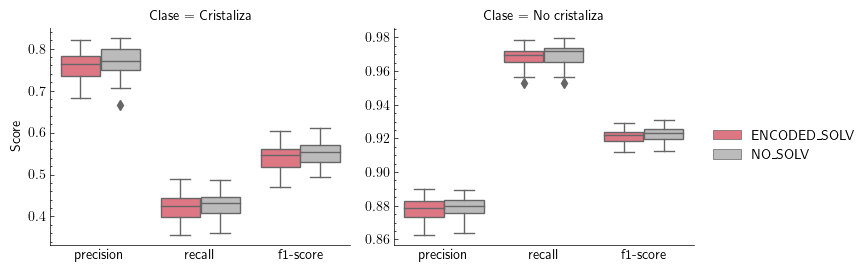

In [122]:
df_box_exp_1 = filter_metrics_classes(df_exp_1)

exp_1_boxplot_classes(df_box_exp_1, plot_name="by_classes_gbc_wei.pdf")

In [123]:
df_exp_2["Exp"] = np.where(df_exp_2['Tipo'].str.contains("MONO"), "MONO_SV", "MULTI_SV")

def func(row):
    sv = "DMSO"
    if sv in row['Tipo']:
        return sv
    elif "DMF" in row['Tipo']:
        return 'DMF' 
    else:
        return 'GBL'

df_exp_2['Solvente'] = df_exp_2.apply(func, axis=1)

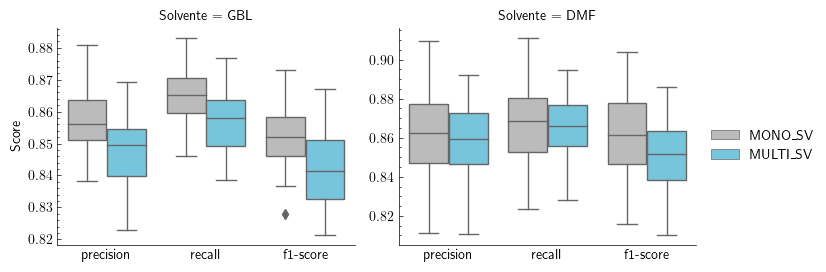

In [141]:
df_box_exp_2 = filter_metrics(df_exp_2)
df_box_exp_2 = df_box_exp_2[df_box_exp_2["Solvente"]!='DMSO']
exp_2_boxplot(df_box_exp_2[df_box_exp_2["Clase"] == "weighted avg"], 
              shared_y=False, 
              plot_name="exp_2_by_sv_gbc_wei.pdf")

In [146]:
df_box_exp_2 = df_exp_2[(df_exp_2["Métrica"] == "matthew") & (df_exp_2["Clase"] == "weighted avg")]
df_box_exp_2 = df_box_exp_2[df_box_exp_2["Solvente"]!='DMSO']

In [147]:
df_box_exp_2 = df_box_exp_2[df_box_exp_2["Score"]!=0]

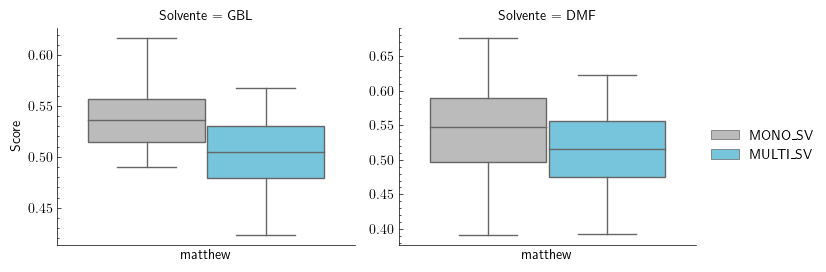

In [148]:
exp_2_boxplot(df_box_exp_2, 
              shared_y=False, 
              plot_name="exp_2_by_sv_gbc_matt.pdf")

In [106]:
encoded_solvent_report = prepare_report_by_class(files_solvent_exp)
drop_solvent_report = prepare_report_by_class(files_drop_col_exp)

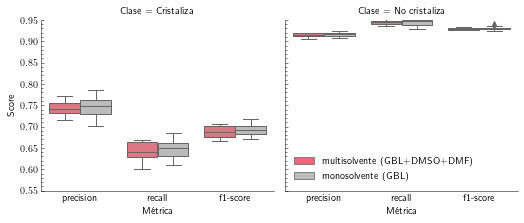

In [138]:
plot_biboxplot(encoded_solvent_report)

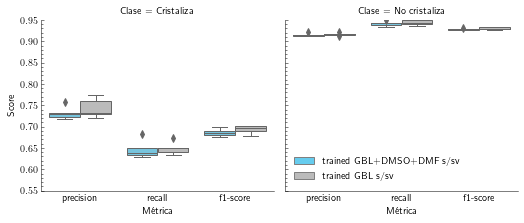

In [139]:
plot_biboxplot_2(drop_solvent_report)